In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
# Importamos nuestras propias funciones
sys.path.append('drive/MyDrive/TFG/src/')

In [ ]:
# from google.colab import files
# files.view('drive/MyDrive/TFG/evaluation.py')

<IPython.core.display.Javascript object>

In [ ]:
from numpy import array, concatenate
import keras
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, RepeatVector
from sklearn.metrics import  mean_absolute_error, r2_score
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from data_preparation import train_test_split, scale
from supervised_learning import to_supervised, prior_inverse, invert_scale
from evaluation import measure_rmse, summarize_scores
from data_visualization import boxplot_errors, plot_loss, plot_metrics, plot_pred_vs_real, residuals_dist, residuals_vs_pred

# fit a model
def model_fit(train_x, train_y, test_x, test_y, config):
  # unpack config
  n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout = config

  # Prepare data
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[0]

  early_stopping = EarlyStopping(patience=5, monitor='loss')
  # define model
  model = keras.Sequential()
  model.add(Conv1D(filters=n_filters, kernel_size=n_kernel,
                                   activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Conv1D(filters=n_filters, kernel_size=n_kernel,
                                   activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  # fit
  history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[early_stopping],  validation_data = (test_x, test_y))
  # print(model.summary())
  return model, history

# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_input, _, _, _, _, _, _ = config
  # prepare data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  x_input = data[-n_input:]
  x_input = x_input.reshape((1, n_input, x_input.shape[1]))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]


# walk-forward validation for univariate data
def walk_forward_validation(data, start_test, cfg):
  # split dataset
  train, test = train_test_split(data, start_test)

  # prepare data
  train = train.to_numpy()
  test = test.to_numpy()

  # Escalamos entre 0 y 1
  scaler, train_scaled, test_scaled = scale(train, test, 0, 1)

  n_steps, _, _, _, _, _, _ = cfg
  # Dividimos en arrays las valores de entrenamiento y test
  train_x, train_y = to_supervised(train_scaled, n_steps)
  test_x, test_y = to_supervised(test_scaled, n_steps)
  # fit model
  model, history = model_fit(train_x, train_y, test_x, test_y, cfg)
  # seed history with training dataset
  history_train = [x for x in train_x]
  # step over each time-step in the test set
  predictions = list()
  for i in range(len(test_x)):
    # fit model and make forecast for history
    yhat = model_predict(model, history_train, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history_train.append(test_x[i])

  predictions = concatenate(predictions).reshape(-1)

  # Obtenemos los valores en la escala inicial
  power_pred, power_real = invert_scale(scaler, test_x, test_y, predictions)

  rmse = measure_rmse(power_real, power_pred)
  mae =  mean_absolute_error(power_real, power_pred)
  r2 = r2_score(power_real, power_pred)
  # plot_history(history)
  return rmse, mae, r2, history, power_pred, power_real

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
  # convert config to a key
  key = str(config)
  # fit and evaluate the model n times
  inicio = time.time()
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  fin = time.time()
  # Calcular la duración en segundos
  duracion_segundos = fin - inicio

  # Convertir la duración a minutos y segundos
  duracion_minutos, duracion_segundos = divmod(duracion_segundos, 60)
  print(key, "Tiempo transcurrido:", int(duracion_minutos), "minutos y", int(duracion_segundos), "segundos")
  return (key, scores)

# grid search configs
def grid_search(data, cfg_list, n_test):
  # evaluate configs
  scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
  return scores

### Energía fotovoltaica

In [ ]:
import pandas as pd
import time
# Datos totales de energía fotovoltaica
df = pd.read_csv('drive/MyDrive/TFG/data/PV_data.csv', index_col='Time')

# Datos primer año
divide = '2020-01-01'
first_year = df.loc[:divide]

# Configuraciones a testear
# n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
configs =  [[24, 16, 2, 50, 15, 150, 0.3], [24, 32, 2, 30, 30, 150, 0.2]]

# Fecha inicial del test
start_test = '2019-09-31'
scores_1 = grid_search(first_year, configs, start_test)

[24, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 2 minutos y 35 segundos
[24, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 2 minutos y 33 segundos


In [ ]:
# Datos segundo año
# divide = '2020-01-01'
second_year = df.loc[divide:]

# Configuraciones a testear
# n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
# configs =  [[24, 16, 2, 50, 15, 150, 0.3], [24, 32, 2, 30, 30, 150, 0.2]]

# Fecha inicial del test
start_test = '2020-09-31'
scores_2 = grid_search(second_year, configs, start_test)

[24, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 2 minutos y 25 segundos
[24, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 2 minutos y 27 segundos


Config [24, 16, 2, 50, 15, 150, 0.3]
                RMSE       MAE        R2
Iteración 1  7.10908  3.933739  0.722993
Iteración 2  8.38130  4.847688  0.611024
cnn: 7.745 RMSE (+/- 0.636)
cnn: 4.391 MAE (+/- 0.457)
cnn: 0.667 R2 (+/- 0.056)


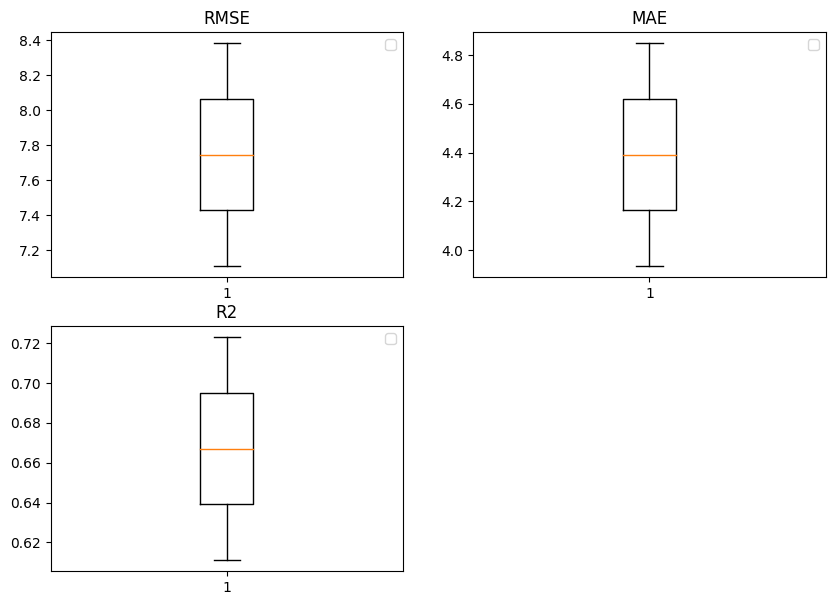

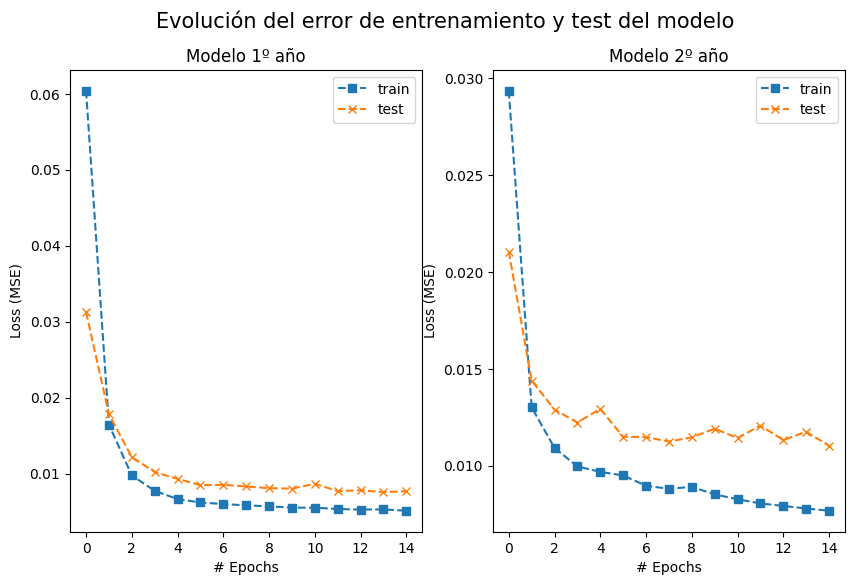

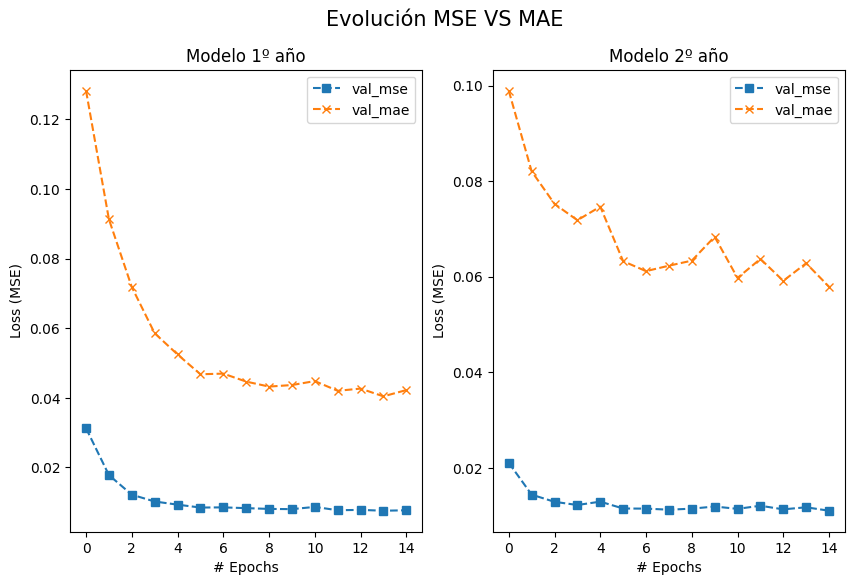

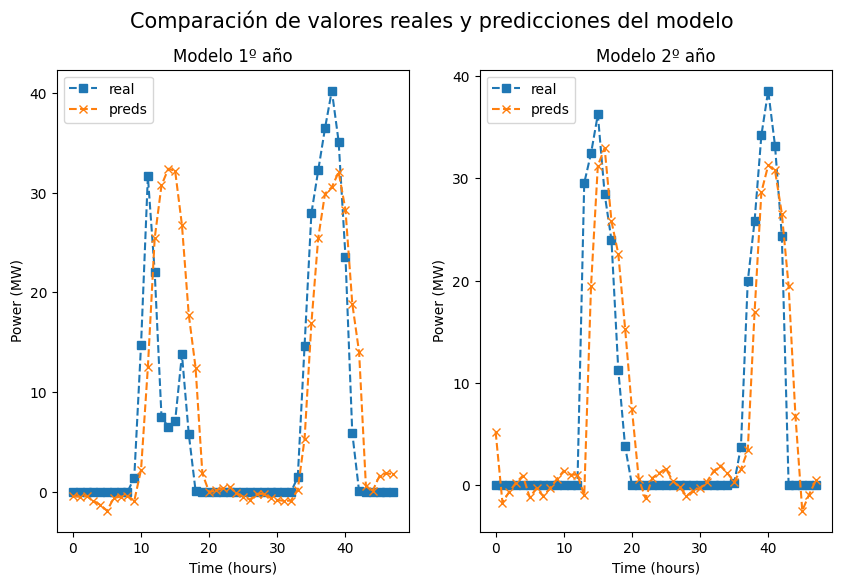

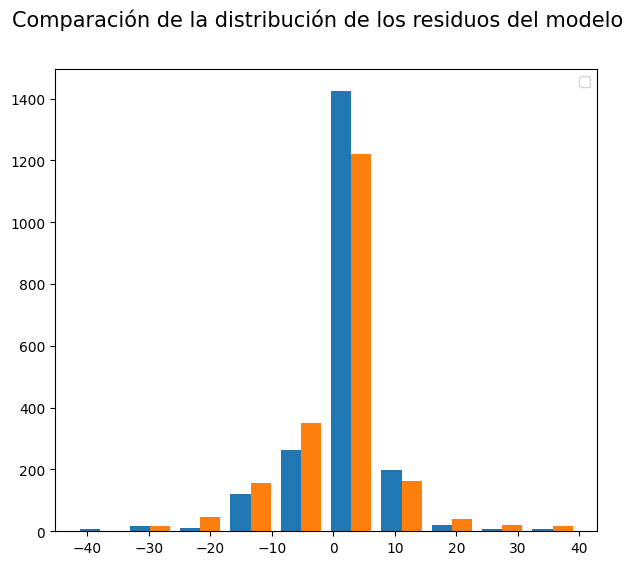

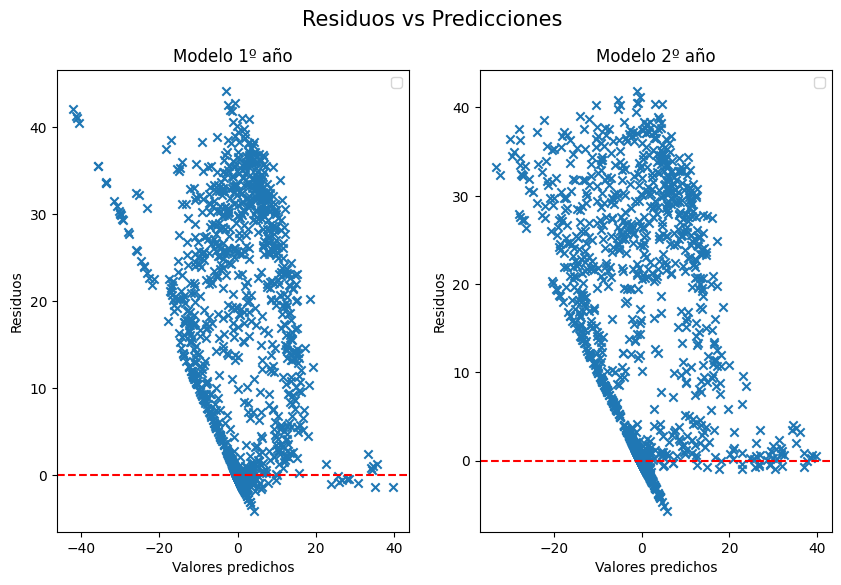

Config [24, 32, 2, 30, 30, 150, 0.2]
                 RMSE       MAE        R2
Iteración 1  6.750045  3.666100  0.750266
Iteración 2  8.686908  4.983807  0.582140
cnn: 7.718 RMSE (+/- 0.968)
cnn: 4.325 MAE (+/- 0.659)
cnn: 0.666 R2 (+/- 0.084)


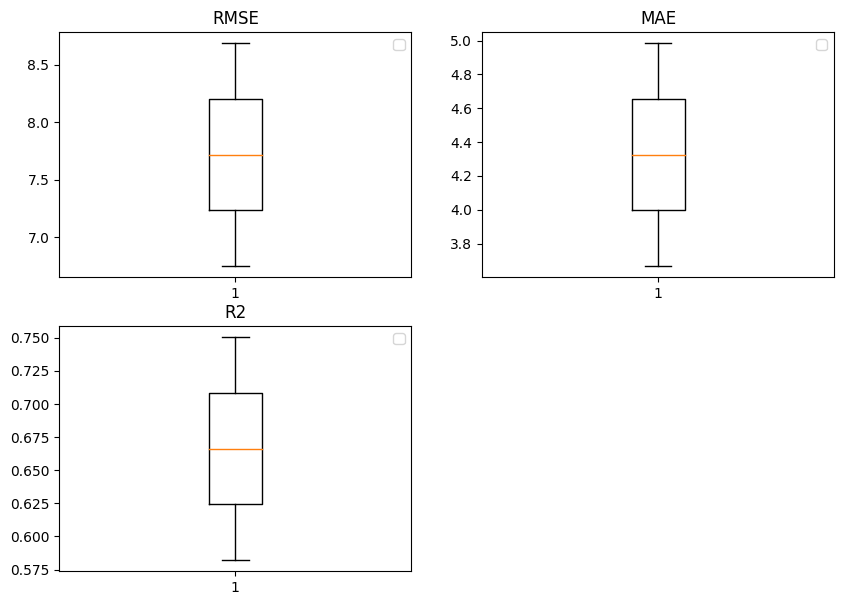

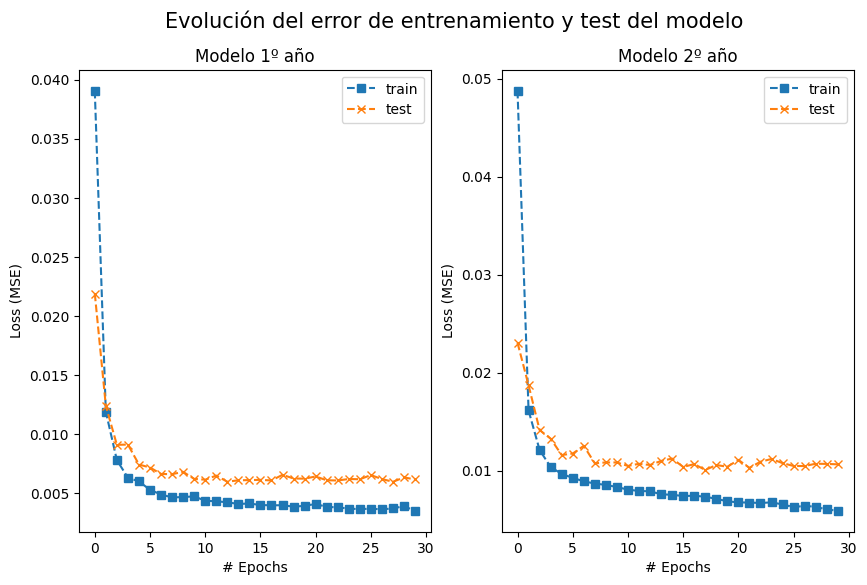

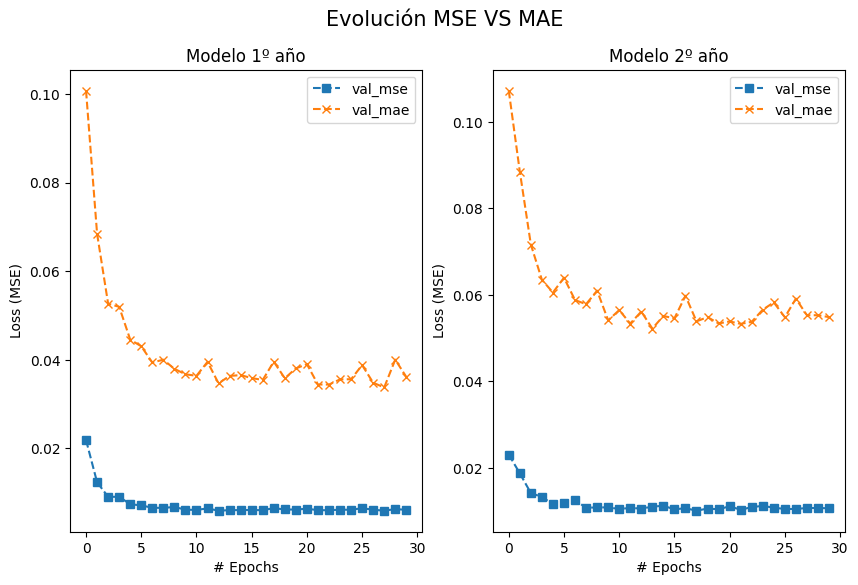

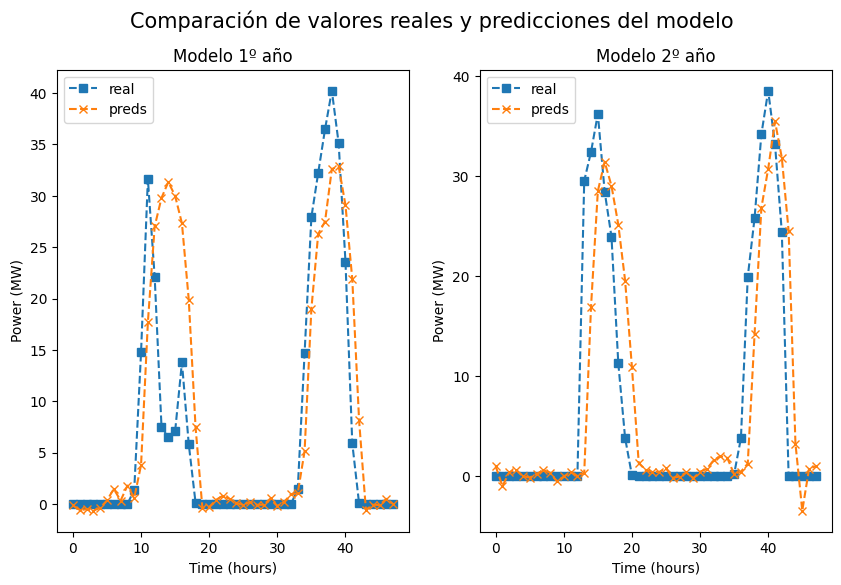

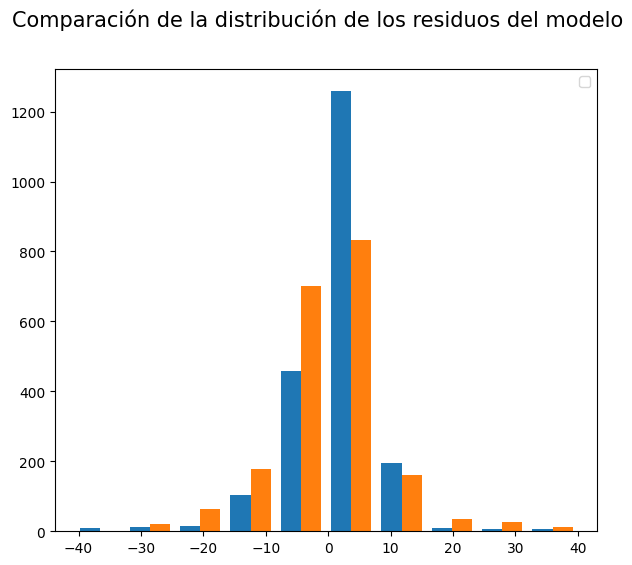

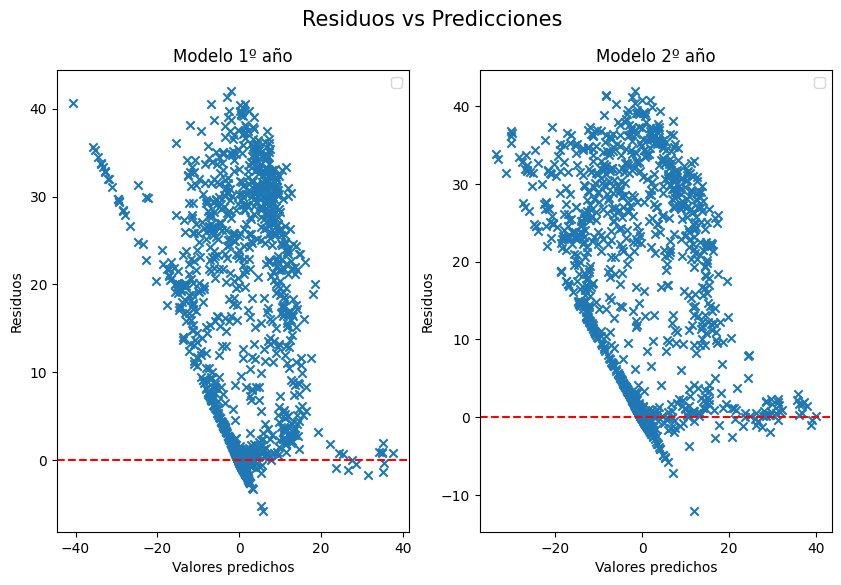

In [ ]:
scores = {config_1: (results_1, results_2) for (config_1, results_1), (config_2, results_2) in zip(scores_1, scores_2) if config_1 == config_2}
summarize_scores('cnn', scores)

### Energía eólica

In [ ]:
# Datos totales de la energía eólica
df = pd.read_csv('drive/MyDrive/TFG/data/EO_data.csv', index_col='Time')

# Datos primer año
# divide = '2020-01-01'
first_year = df.loc[:divide]

# Configuraciones a testear
# n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
configs =  [[24*7, 16, 2, 50, 15, 150, 0.3], [24*7, 32, 2, 30, 30, 150, 0.2]]


# Fecha inicial del test
start_test = '2019-09-31'
scores_1 = grid_search(first_year, configs, start_test)

[168, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 2 minutos y 49 segundos
[168, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 2 minutos y 40 segundos


In [ ]:
# df = pd.read_csv('drive/MyDrive/TFG/data/EO_data.csv', index_col='Time')

# Datos segundo año
# divide = '2020-01-01'
second_year = df.loc[divide:]

# Configuraciones a testear
# n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, dropout
# configs =  [[24*7, 16, 2, 50, 15, 150, 0.3], [24*7, 32, 2, 30, 30, 150, 0.2]]

start_test = '2020-09-31'
scores_2 = grid_search(second_year, configs, start_test)

[168, 16, 2, 50, 15, 150, 0.3] Tiempo transcurrido: 2 minutos y 38 segundos
[168, 32, 2, 30, 30, 150, 0.2] Tiempo transcurrido: 2 minutos y 41 segundos


Config [168, 16, 2, 50, 15, 150, 0.3]
                  RMSE       MAE        R2
Iteración 1  14.283737  9.825918  0.691753
Iteración 2  14.682890  9.544491  0.648707
cnn: 14.483 RMSE (+/- 0.200)
cnn: 9.685 MAE (+/- 0.141)
cnn: 0.670 R2 (+/- 0.022)


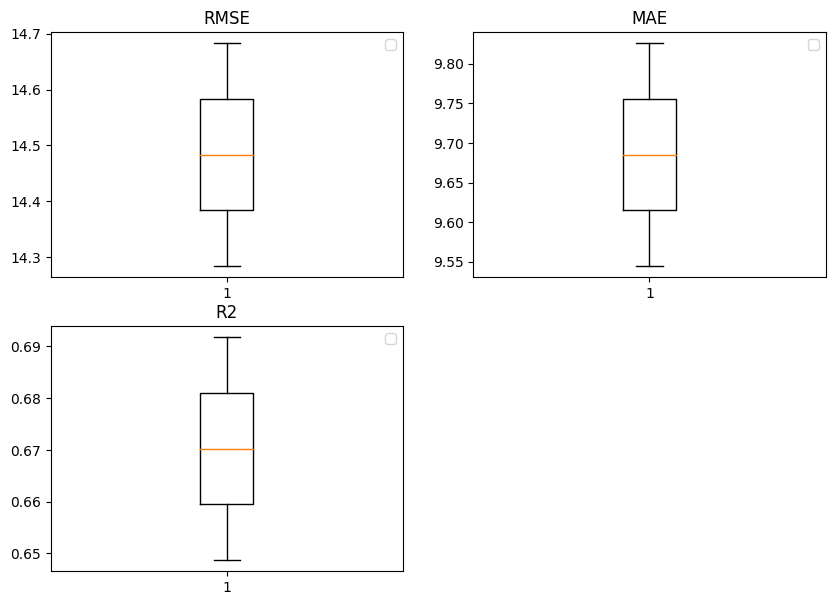

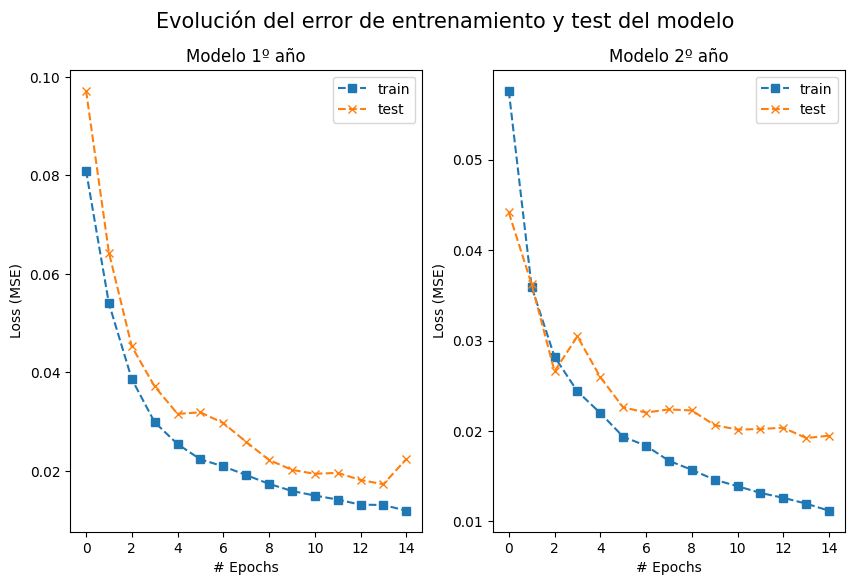

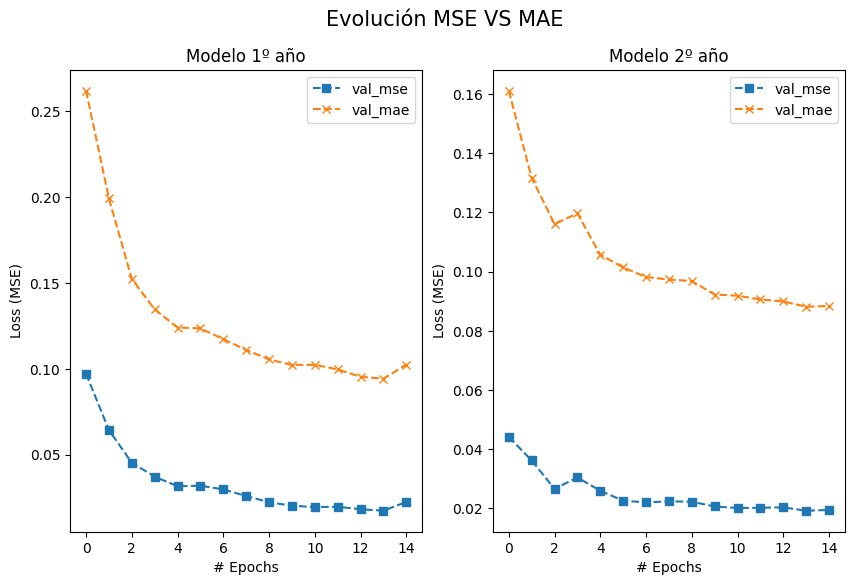

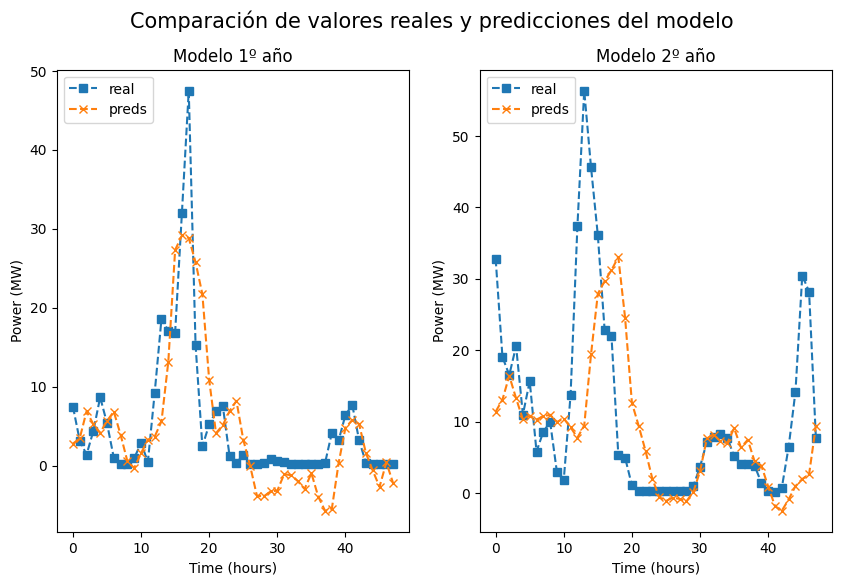

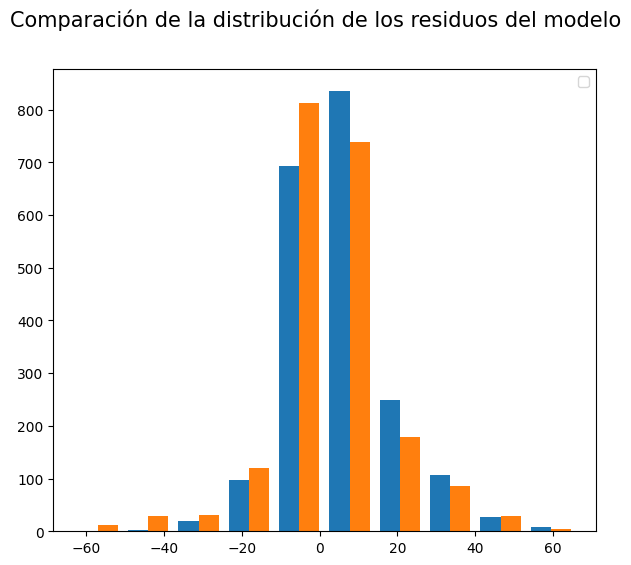

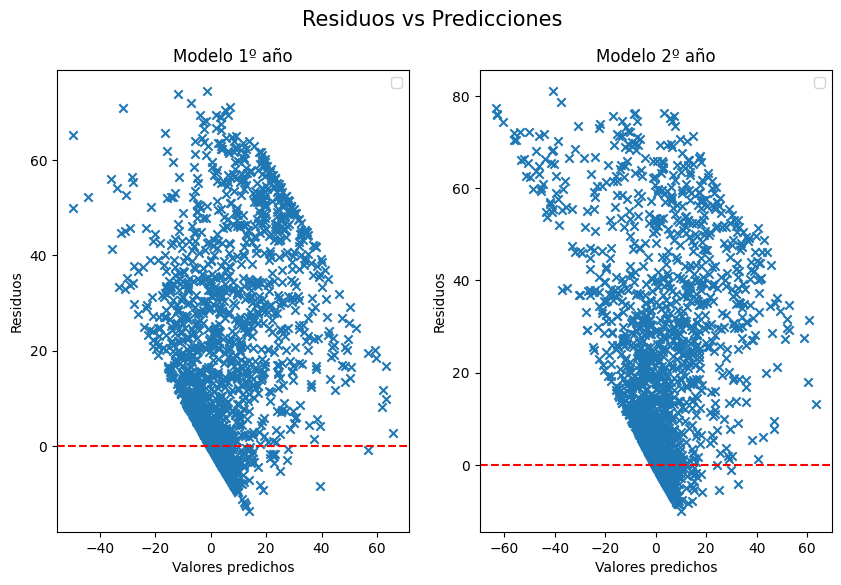

Config [168, 32, 2, 30, 30, 150, 0.2]
                  RMSE       MAE        R2
Iteración 1  12.909970  8.128174  0.748194
Iteración 2  15.682788  9.784739  0.599232
cnn: 14.296 RMSE (+/- 1.386)
cnn: 8.956 MAE (+/- 0.828)
cnn: 0.674 R2 (+/- 0.074)


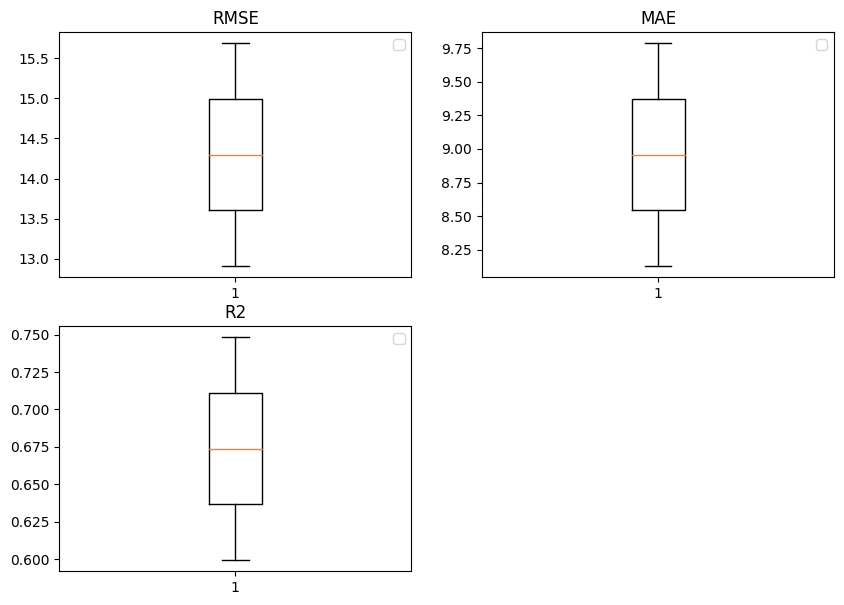

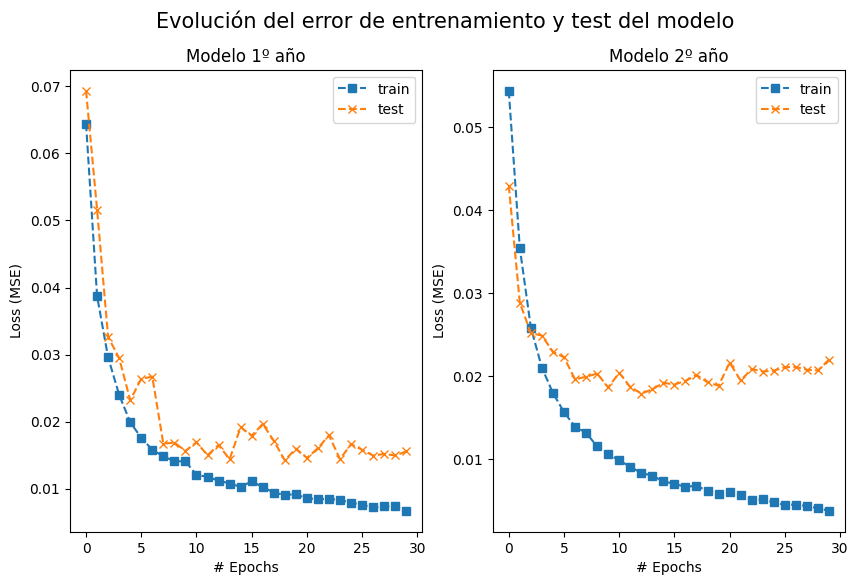

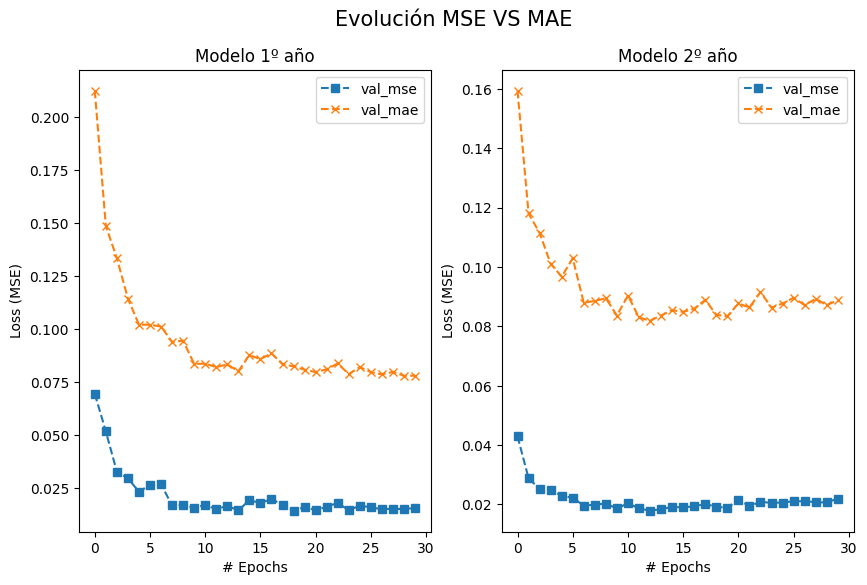

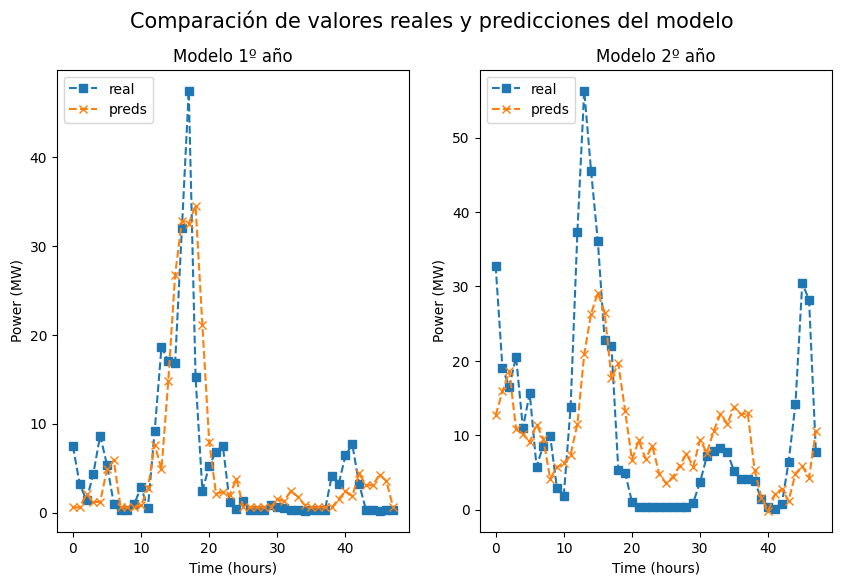

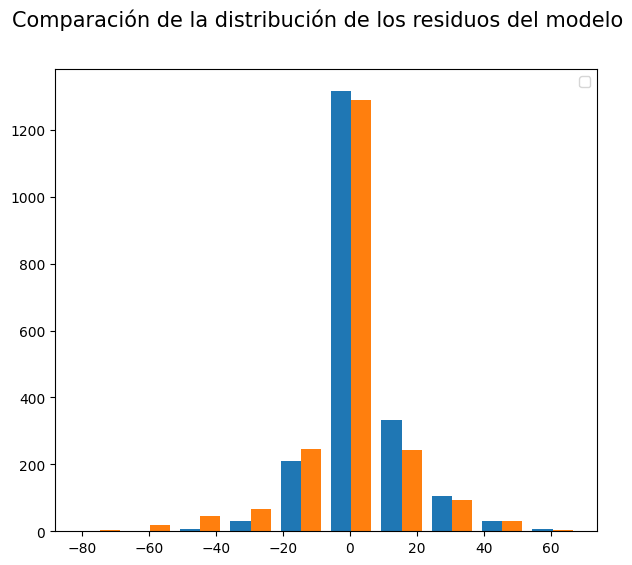

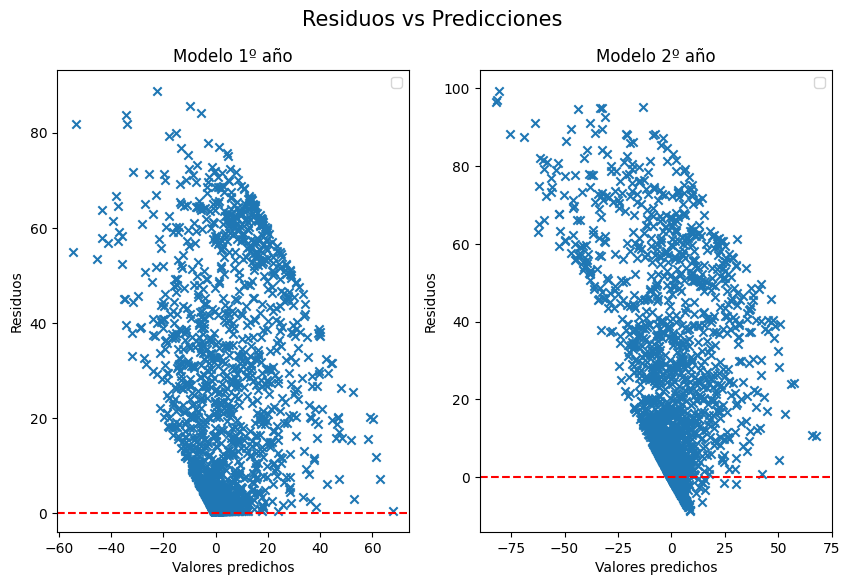

In [ ]:
scores = {config_1: (results_1, results_2) for (config_1, results_1), (config_2, results_2) in zip(scores_1, scores_2) if config_1 == config_2}
summarize_scores('cnn', scores)